In [ ]:
!pip install -r requirements.txt
!pip install opencv-python-headless
!pip install pretrainedmodels

In [ ]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import segmentation
import pretrainedmodels
from utils import *
import cv2
from PIL import Image
import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2,ToTensor
from albumentations.augmentations.transforms import ColorJitter

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import segmentation_models_pytorch as smp
plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

random_seed = 14
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


In [ ]:
!git clone https://github.com/Cadene/pretrained-models.pytorch.git
!cd pretrained-models.pytorch
!python setup.py install

Cloning into 'pretrained-models.pytorch'...
remote: Enumerating objects: 803, done.
remote: Total 803 (delta 0), reused 0 (delta 0), pack-reused 803
Receiving objects: 100% (803/803), 522.66 KiB | 1011.00 KiB/s, done.
Resolving deltas: 100% (491/491), done.


In [ ]:
model_name="xception"
temp_model=pretrainedmodels.__dict__[model_name](num_classes=1000,pretrained="imagenet")
temp_model

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /opt/ml/.cache/torch/checkpoints/xception-43020ad28.pth


  0%|          | 0.00/87.4M [00:00<?, ?B/s]

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [ ]:
d=torch.randn(2,3,512,512)
temp_model.features(d).shape

torch.Size([2, 2048, 16, 16])

## 하이퍼파라미터 세팅 및 seed 고정

## 학습 데이터 EDA

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617
       Categories  Number of annotations
0       Backgroud                    NaN
1         UNKNOWN                  128.0
2   General trash                 2225.0
3           Paper                 7448.0
4      Paper pack                  527.0
5           Metal                  449.0
6           Glass                  488.0
7         Plastic                 2472.0
8       Styrofoam                 1074.0
9     Plastic bag                 6114.0
10        Battery                   50.0
11       Clothing                  141.0


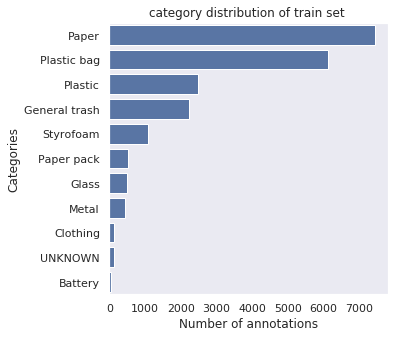

In [ ]:
import gc
gc.collect()

%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
print(sorted_df)

## 데이터 전처리 함수 정의 (Dataset)

In [ ]:
# seed 고정

category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        #images/=255.0
        
        #images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.uint8)
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
        
            if self.transform is not None:
                transformed = self.transform(image=images,mask=masks)
                images=transformed['image']
                masks=transformed['mask']
            return images, masks, image_infos
        
        if self.mode == 'test1' or self.mode=='test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                images = self.transform(image=images)['image']
            
            return images, image_infos
    
        
        if self.mode == 'test2':
            # transform -> albumentations 라이브러리 활용
            images/=255.0
            if self.transform is not None:
                images = self.transform(image=images)['image']
            
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [ ]:
batch_size = 8  # Mini-batch size
num_epochs = 10
learning_rate = 5e-5

## Dataset 정의 및 DataLoader 할당

In [ ]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train_all.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


train_transform = A.Compose([A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),ToTensorV2()])
#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)), 
    


val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)
#print(len(train_dataset))
# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn,
                                           drop_last = True)
val_loader=None
#val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                          batch_size=batch_size,
#                                          shuffle=False,
#                                          num_workers=4,
#                                          collate_fn=collate_fn,
#                                          drop_last = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn,drop_last=True)

loading annotations into memory...
Done (t=7.20s)
creating index...
index created!
loading annotations into memory...
Done (t=1.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


In [ ]:
test_dataset[0][0]

tensor([[[0.3490, 0.3216, 0.2941,  ..., 0.1098, 0.1098, 0.1098],
         [0.3137, 0.3059, 0.2863,  ..., 0.1098, 0.1059, 0.1059],
         [0.2275, 0.2314, 0.2235,  ..., 0.1059, 0.1059, 0.1020],
         ...,
         [0.2980, 0.2471, 0.2392,  ..., 0.4353, 0.2627, 0.2510],
         [0.2471, 0.2157, 0.2235,  ..., 0.4118, 0.2588, 0.2667],
         [0.2471, 0.2157, 0.2314,  ..., 0.4471, 0.2941, 0.2667]],

        [[0.3373, 0.3098, 0.2824,  ..., 0.0784, 0.0784, 0.0784],
         [0.3020, 0.2941, 0.2745,  ..., 0.0784, 0.0745, 0.0745],
         [0.2157, 0.2196, 0.2118,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2275, 0.1765, 0.1686,  ..., 0.3922, 0.2157, 0.2118],
         [0.1765, 0.1451, 0.1529,  ..., 0.3686, 0.2118, 0.2196],
         [0.1765, 0.1451, 0.1608,  ..., 0.4000, 0.2471, 0.2196]],

        [[0.3020, 0.2745, 0.2471,  ..., 0.0706, 0.0706, 0.0706],
         [0.2667, 0.2588, 0.2392,  ..., 0.0706, 0.0667, 0.0667],
         [0.1804, 0.1843, 0.1765,  ..., 0.0667, 0.0667, 0.

### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {3, 'Paper'}, {'Plastic bag', 9}]


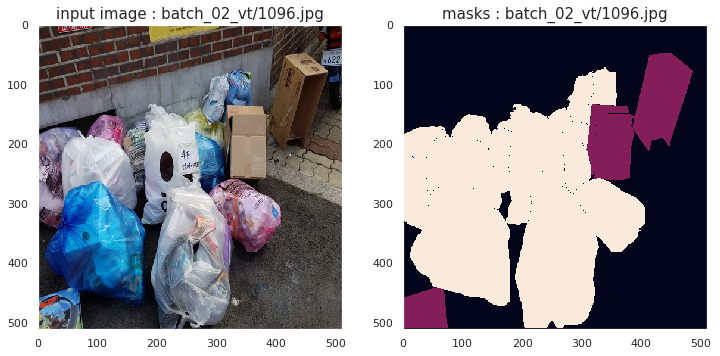

In [ ]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

In [ ]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

TypeError: 'NoneType' object is not iterable

In [ ]:
# test_loader의 output 결과(image 및 mask) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    # temp_masks = masks
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F




class DeepLabV3(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(DeepLabHead, self).__init__(
            ASPP(in_channels, [12, 24, 36]),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1)
        )


class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

In [ ]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
import torchvision.models.segmentation 
model=deeplabv3_resnet101(pretrained=False,num_classes=12)
#model = DeepLabV3(n_classes=12, n_blocks=[3, 4, 23, 3], atrous_rates=[6, 12, 18, 24])
# backbone
x = torch.randn([2, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x)['out'].to(device)
print("output shape : ", out.size())

model = model.to(device)

In [ ]:

class MyModel(nn.Module):
    def __init__(self, num_classes=12,optional_dilation_list=None,use_aux=None):
        super(MyModel, self).__init__()
        self.use_aux=use_aux
        self.optional_dilation_list=optional_dilation_list
        self.backbone=segmentation.deeplabv3_resnet101(pretrained=True,aux_loss=self.use_aux)
        self.backbone.classifier[-1]=nn.Conv2d(256,num_classes,kernel_size=(1,1),stride=(1,1))
        if self.optional_dilation_list is not None:
            add_dilation=len(self.optional_dilation_list)
            for dilation in self.optional_dilation_list:
                self.backbone.classifier[0].convs.append(nn.Sequential(nn.Conv2d(2048, 256, 3, padding=dilation, dilation=dilation, bias=False),nn.BatchNorm2d(256),nn.ReLU()))
            self.backbone.classifier[0].project[0]=nn.Conv2d(256*(5+add_dilation),256,kernel_size=(1,1),stride=(1,1))
            #print(self.backbone.classifier[0])
        self.backbone.aux_classifier[-1]=nn.Conv2d(256,num_classes,kernel_size=(1,1),stride=(1,1))
        
    def forward(self, x):
#         x2=self.backbone.backbone(x.clone())
#         print(x2['out'].shape)# 2048,64,64
#         x2=self.backbone.classifier[0](x2['out'])
#         #
#         print(x2.shape)
#         x2=self.backbone.classifier[1](x2)
#         print(x2.shape)
#         x2=self.backbone.classifier[2](x2)
#         print(x2.shape)
#         x2=self.backbone.classifier[3](x2)
#         print(x2.shape)
#         x2=self.backbone.classifier[4](x2)
#         print(x2.shape)
        
        x=self.backbone(x)
        if(self.use_aux==None):
            x['aux']=None
        return x
#MyModel()

In [ ]:

class MyModel2(nn.Module):
    def __init__(self, num_classes=12):
        super(MyModel2, self).__init__()
        self.encoder=pretrainedmodels.__dict__["xception"](num_classes=1000,pretrained='imagenet')
        #self.encoder.bn4=nn.Identity()
        self.encoder.last_linear=nn.Identity()
        self.base=smp.DeepLabV3Plus(encoder_name="resnext101_32x8d",in_channels=3,classes=num_classes)
        self.decoder=self.base.decoder
        self.head=self.base.segmentation_head
        self.head[1]=nn.UpsamplingBilinear2d(scale_factor=8.0)
        #print(self.base)
        #print(self.encoder)
        #print(self.head)
    def forward(self, x):
        features=[]
        features.append(x.clone())
        x1=self.encoder.conv1(x)
        x1=self.encoder.bn1(x1)
        x1=self.encoder.relu(x1)
        x1=self.encoder.conv2(x1)
        x1=self.encoder.bn2(x1)
        features.append(x1)
        x2=self.encoder.block1(x1)
        features.append(x2)
        x3=self.encoder.block2(x2)
        features.append(x3)
        
        x4=self.encoder.block3(x3)
        x4=self.encoder.block4(x4)
        x4=self.encoder.block5(x4)
        x4=self.encoder.block6(x4)
        x4=self.encoder.block7(x4)
        x4=self.encoder.block8(x4)
        x4=self.encoder.block9(x4)
        x4=self.encoder.block10(x4)
        x4=self.encoder.block11(x4)
        features.append(x4)
        
        x5=self.encoder.block12(x4)
        features.append(x5)
        
        x6=self.encoder.conv3(x5)
        x6=self.encoder.bn3(x6)
        x6=self.encoder.conv4(x6)
        x6=self.encoder.bn4(x6)
        features.append(x6)
        
        
#         for i in features:
#             print(i.shape)
#         features=[torch.randn(2,3,512,512),torch.randn(2,64,256,256),torch.randn(2,256,128,128),torch.randn(2,512,64,64),torch.randn(2,1024,32,32),torch.randn(2,2048,32,32)]
        
        x=self.decoder(*features)
        x=self.head(x)
        return x
#MyModel2()

In [ ]:
class MyModel3(nn.Module):
    def __init__(self, num_classes=12):
        super(MyModel3, self).__init__()
        self.backbone=smp.DeepLabV3Plus(encoder_name="resnext101_32x8d",in_channels=3,classes=num_classes)
        
    def forward(self, x):
        x=self.backbone(x)
        return x
#MyModel3()

## train, validation, test 함수 정의

In [ ]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    """모델 학습을 위한 함수
    
    Args:
        num_epochs(int) : 학습 에폭 수
        model(nn.Module) : 모델
        data_loader(DataLoader) : 학습 데이터 로더
        val_loader(DataLoader) : validation 데이터 로더
        criterion(loss func) : loss function
        optimizer(optimizer func) : optimizer function
        save_dir(str) : 모델 저장 공간
        val_every(int) : validation 주기
        device(device) : 사용 device
    """ 
    print('Start training..')
    best_mIoU = 0
    
    for epoch in range(num_epochs):
        model.train()
        mIoU_list=[]
        cnt=0
        hist=np.zeros((12,12))
        for step, (images, masks, _) in enumerate(data_loader):
            cnt+=1
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # train_all 시, step마다 miou 누적계산
            if(val_loader==None):
                outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()
                hist=add_hist(hist, masks.detach().cpu().numpy(), outputs, n_class=12)
                acc, acc_cls, mIoU, fwavacc = label_accuracy_score(hist)
                mIoU_list.append(mIoU)
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(data_loader), loss.item()))
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        
        if (epoch + 1) % val_every == 0:
            # train_all 시, epoch마다 validation 대신 train 간 평균 mIoU best model 저장.
            if(val_loader==None):
                train_epoch_miou=np.mean(mIoU_list)
                if train_epoch_miou > best_mIoU:
                    print('Best performance at epoch: {} , mIoU : {}'.format(epoch + 1,train_epoch_miou))
                    print('Save model in', saved_dir)
                    best_mIoU = train_epoch_miou
                    save_model(model, saved_dir)
            else:
            # validation 간 best mIoU 모델 저장
                avgr_loss,val_epoch_miou = validation(epoch + 1, model, val_loader, criterion, device)
                if val_epoch_miou > best_mIoU:
                    print('Best performance at epoch: {} , val_mIoU: {}'.format(epoch + 1,val_epoch_miou))
                    print('Save model in', saved_dir)
                    best_mIoU = val_epoch_miou
                    save_model(model, saved_dir)

In [ ]:
def validation(epoch, model, data_loader, criterion, device): # --> 요거 아예안쓰고요
    print('Start validation #{}'.format(epoch))
    #logger.info('Start validation #{}'.format(epoch))
    model.eval()
    hist=np.zeros((12,12))
    mmiou=0
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()
            hist=add_hist(hist, masks.detach().cpu().numpy(), outputs, n_class=12)
            acc, acc_cls, mIoU, fwavacc = label_accuracy_score(hist)
            mIoU_list.append(mIoU)
        mmiou=np.mean(mIoU_list)
            
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, mmiou))
    return avrg_loss,mmiou

## 모델 저장 함수 정의

In [ ]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='basemodel_insta_epoch.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [ ]:
gc.collect()
torch.cuda.empty_cache()

model=MyModel3().to(device)
# Loss function 정의
criterion = nn.CrossEntropyLoss()
#criterion = LabelSmoothingLoss(classes=12,smoothing=0.1)
# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [ ]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)
#15:03 epoch당 10min. 9개 남았으니까... 90

#def nn.Module criterion . rfofk

Start training..
Epoch [1/9], Step [25/409], Loss: 1.7710
Epoch [1/9], Step [50/409], Loss: 1.6041
Epoch [1/9], Step [75/409], Loss: 1.0586
Epoch [1/9], Step [100/409], Loss: 1.0589
Epoch [1/9], Step [125/409], Loss: 0.8408
Epoch [1/9], Step [150/409], Loss: 0.7707
Epoch [1/9], Step [175/409], Loss: 0.7686
Epoch [1/9], Step [200/409], Loss: 0.7860
Epoch [1/9], Step [225/409], Loss: 0.6243
Epoch [1/9], Step [250/409], Loss: 0.6537
Epoch [1/9], Step [275/409], Loss: 0.5987
Epoch [1/9], Step [300/409], Loss: 0.7071
Epoch [1/9], Step [325/409], Loss: 0.7526
Epoch [1/9], Step [350/409], Loss: 0.5904
Epoch [1/9], Step [375/409], Loss: 0.3543
Epoch [1/9], Step [400/409], Loss: 0.5216
Best performance at epoch: 1 , mIoU : 0.20014198104687356
Save model in ./saved
Epoch [2/9], Step [25/409], Loss: 0.3956
Epoch [2/9], Step [50/409], Loss: 0.4284
Epoch [2/9], Step [75/409], Loss: 0.4074
Epoch [2/9], Step [100/409], Loss: 0.2948
Epoch [2/9], Step [125/409], Loss: 0.5151
Epoch [2/9], Step [150/409]

## 저장된 model 불러오기 (학습된 이후) 

In [ ]:

# best model 저장된 경로
model=smp.DeepLabV3Plus(encoder_name="timm-regnety_320",classes=12)
#print(model)
model_path = './saved/regnety_myconfig_2fold.pt'

#model_path = './saved/bestmIoU_dilateup_intensity.pt'

# best model 불러오기
# print(model)
#checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(torch.load(model_path, map_location=device))
#print(len(checkpoint))
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
model=model.to(device)
model.eval()

DeepLabV3Plus(
  (encoder): RegNetEncoder(
    (stem): ConvBnAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (act): ReLU(inplace=True)
      )
    )
    (s1): RegStage(
      (b1): Bottleneck(
        (conv1): ConvBnAct(
          (conv): Conv2d(32, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): ReLU(inplace=True)
          )
        )
        (conv2): ConvBnAct(
          (conv): Conv2d(232, 232, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): ReLU(inplace=True)
          )
        )
        (se): SEModule(
          (fc1): Conv2d(232, 8, kernel_size=(

## submission을 위한 test 함수 정의

In [ ]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model=model.to(device)
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [ ]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)
# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/regnet_2fold2.csv", index=False)


Start prediction.
End prediction.


## TTA



In [ ]:
def test_TTA(TTA,model,test_dataset,test_aug,device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):
            #imgs = bx3x512x512
            outs=np.zeros((len(imgs),12,512,512),dtype=np.float32)
            
            imgs=list(map(np.asarray,imgs))
            imgs=np.asarray(imgs)
            
            for tta in range(TTA):
                #out에는 배치째로 넣는거 맞음.
                # for img in imgs 해서, img 각각 aug진행 뒤 교체
                transposed_imgs=imgs.transpose(0,2,3,1)
                augmented_input=[]
                for img_idx,img in enumerate(transposed_imgs):
                    #print(test_aug(image=img)['image'])
                    augmented_input.append(test_aug(image=img)['image'])
                augmented_input=tuple(augmented_input)
                outs = outs+(model(torch.stack(augmented_input).to(device)).to(device)).cpu().numpy()
            outs=outs/TTA
            out_d=[]
            for out in outs:
                out_d.append(out)
            out_d=torch.Tensor(out_d)
            oms = torch.argmax(out_d.squeeze(), dim=1).detach().cpu().numpy()
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            
            preds_array = np.vstack((preds_array, oms))
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
             
    return file_names,preds_array

In [ ]:
# sample_submisson.csv 열기

submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)
TTA=5
test_aug=A.Compose([ColorJitter(0.3,0.3,0,0,p=0.5),ToTensorV2()])
# test set에 대한 prediction
if(TTA>1):
    file_names, preds = test_TTA(TTA,model,test_loader,test_aug,device)
    print(preds)
else:
    file_names, preds = test(model, test_loader, device)
    #print(preds)
# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/bestmodel_TTA2.csv", index=False)

Start prediction.
End prediction.
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# soft ensemble

In [ ]:
from efficientb7_DeepLabv3_timm import DeepLabV3EffiB7Timm

model1=smp.DeepLabV3Plus(encoder_name="timm-regnety_320",classes=12) #0.5997 /=255빼고 노멀라이즈
model_path = './saved/5997.pt'
model1.load_state_dict(torch.load(model_path, map_location=device))


# model2=smp.DeepLabV3Plus(encoder_name="timm-regnety_320",classes=12) #0.5832 /=255빼고 노멀라이즈
# model_path = './saved/5832.pt'
# model2.load_state_dict(torch.load(model_path, map_location=device))

model3=smp.DeepLabV3Plus(encoder_name="timm-regnety_320",classes=12) #0.5996 /=255빼고 노멀라이즈
model_path = './saved/5996.pt'
model3.load_state_dict(torch.load(model_path, map_location=device))

# model4=DeepLabV3EffiB7Timm(n_classes=12, n_blocks=[3, 4, 23, 3], atrous_rates=[6, 12, 18, 24]) #0.59 /=255
# model_path = './saved/59.pt'
# model4.load_state_dict(torch.load(model_path, map_location=device))

model5=MyModel3()#0.6065 /=255
model_path = './saved/6065.pt'
model5.load_state_dict(torch.load(model_path, map_location=device))

model6=MyModel3()#0.6030 /=255
model_path = './saved/6030.pt'
model6.load_state_dict(torch.load(model_path, map_location=device))

model7=DeepLabV3EffiB7Timm(n_classes=12, n_blocks=[3, 4, 23, 3], atrous_rates=[6, 12, 18, 24]) #서윤이거 0.5932
model_path = './saved/5932.pt'
model7.load_state_dict(torch.load(model_path, map_location=device))

model_list=[model1,model3,model5,model6,model7] #5997, 5996, 6065, 6030, (5932)
# best = 5997,5996, 59 , 6065, 6030

In [ ]:
def test_ensemble(model_list, data_loader1,data_loader2,device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    for model in model_list:
        model=model.to(device)
        model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
            
        for step, ((imgs1, image_infos1),(imgs2,image_info2)) in enumerate(zip(data_loader1,data_loader2)):
            
            # inference (512 x 512)
            
            outs1 = model_list[0](torch.stack(imgs1).to(device)).cpu().numpy()
            outs2 = model_list[1](torch.stack(imgs1).to(device)).cpu().numpy()
            outs3 = model_list[2](torch.stack(imgs2).to(device)).cpu().numpy()
            outs4 = model_list[3](torch.stack(imgs2).to(device)).cpu().numpy()
            outs5 = model_list[4](torch.stack(imgs2).to(device)).cpu().numpy()
            #outs6 = model_list[5](torch.stack(imgs2).to(device)).cpu().numpy()
            outs= (outs1+outs2+outs3+outs4+outs5)/5.0
            out_d=[]
            for out in outs:
                out_d.append(out)
            out_d=torch.Tensor(out_d)
            oms = torch.argmax(out_d.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs1), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            
            file_name_list.append([i['file_name'] for i in image_infos1])
                
                
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

In [ ]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)
TTA=5
test_aug_type1=A.Compose([A.Normalize(
                 mean=(0.46446795,0.44277694,0.42146815), 
                 std=(0.21137457,0.20805008,0.21553354), 
                 max_pixel_value=255.0, 
                 p=1.0),ToTensorV2()])
test_aug_type2=A.Compose([ToTensorV2()])

# 모델1,2,3 은 
test_dataset_type1=CustomDataLoader(data_dir=test_path, mode='test1', transform=test_aug_type1)
test_dataset_type2=CustomDataLoader(data_dir=test_path, mode='test2', transform=test_aug_type2)
# loda

test_loader_type1 = torch.utils.data.DataLoader(dataset=test_dataset_type1,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn,drop_last=True)
test_loader_type2 = torch.utils.data.DataLoader(dataset=test_dataset_type2,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn,drop_last=True)


file_names, preds = test_ensemble(model_list, test_loader_type1,test_loader_type2,device)
print(preds)
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/ensemble4.csv", index=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Start prediction.
